# Learning Rate Analysis for Centralized and Federated Experiments

This notebook analyzes the impact of learning rates on model performance for both centralized and federated training experiments within the `mlsys26` workspace. The primary goal is to visualize the relationship between the learning rate schedule and the training/validation loss.

## Overview

The notebook connects to Weights & Biases to perform the following steps:

1.  **Fetch and Group Runs**: It fetches all runs containing "fed" (federated) or "cen" (centralized) in their names. It then intelligently groups individual `wandb` runs into logical experiments. A federated experiment, comprising a server and multiple clients, is treated as a single entity.

2.  **Filter Experiments**: It filters the experiments to ensure data quality and relevance. The filtering criteria include:
    - **Termination Status**: Only experiments where all associated runs have terminated (e.g., 'finished' or 'crashed') are included.
    - **Training Completion**: Ensures that the runs have reached their target number of optimization steps.
    - **Configuration Matching**: Filters for specific model and optimizer configurations, such as batch size, FFN type, and initial learning rate.

3.  **Process Data**: For each logical experiment, it downloads the relevant metrics. To improve performance, it **caches the full history** of each run locally. For federated runs, it aggregates data from all client runs by averaging their metrics at each step.

4.  **Generate Plots**: The notebook produces a **dynamic grid of plots** where each subplot corresponds to a specific model configuration (batch size and FFN type). Within each plot, it visualizes:
    - **Loss vs. Steps**: The training or validation loss curve across optimization steps.
    - **Learning Rate vs. Steps**: The learning rate schedule on a secondary y-axis, providing context for changes in the loss curve.
    - Each line in a plot represents a run with a different initial learning rate, allowing for direct comparison of optimizer performance.

In [1]:
import hashlib
import logging
import math
import re
from collections import defaultdict
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from matplotlib.ticker import FixedLocator, FuncFormatter
from tqdm.notebook import tqdm
from wandb.errors import Error as WandbError

from fedmoe_plots.wandb_utils import download_wandb_whole_history


def configure_logging_for_jupyter() -> None:
    """Configure the root logger for clear output in Jupyter notebooks."""
    root_logger = logging.getLogger()
    if root_logger.hasHandlers():
        root_logger.handlers.clear()
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    )
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)
    root_logger.setLevel(logging.INFO)


configure_logging_for_jupyter()
log = logging.getLogger("lr_analysis.ipynb")

# --- W&B Configuration ---
WANDB_ENTITY = "camlsys"
WANDB_PROJECT = "mlsys26"
CACHE_DIR = Path(".cache/wandb_history")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

DEFAULT_GROUPING_CONFIG_KEYS: dict[str, str] = {
    "batch_size": "llm_config.global_train_batch_size",
    "ffn_type": "llm_config.model.ffn_config.ffn_type",
    "local_steps": "fl.n_local_steps",
    "learning_rate": "llm_config.optimizer.lr",
}

## Utility Functions

In [2]:
def get_nested_value(d: dict[str, Any], key_string: str) -> Any | None:  # noqa: ANN401
    """Access a nested value using a dot-separated key.

    Parameters
    ----------
    d : dict[str, Any]
        The dictionary to access.
    key_string : str
        The dot-separated key string.
        The dot-separated key string.

    Returns
    -------
    Any | None
        The value if found, otherwise None.

    """
    keys = key_string.split(".")
    current_value = d
    for key in keys:
        try:
            if isinstance(current_value, dict):
                current_value = current_value[key]
            elif isinstance(current_value, list | tuple) and key.isdigit():
                current_value = current_value[int(key)]
            else:
                return None
        except (KeyError, IndexError, TypeError):
            return None
    return current_value


In [3]:
def get_run_cache_path(run: wandb.apis.public.Run) -> Path:
    """Generate a cache file path for a W&B run.

    Parameters
    ----------
    run : wandb.apis.public.Run
        The W&B run object.

    Returns
    -------
    Path
        The path to the cached parquet file.

    """
    run_identifier = f"{run.entity}_{run.project}_{run.id}"
    run_hash = hashlib.md5(run_identifier.encode()).hexdigest()[:12]  # noqa: S324
    return CACHE_DIR / f"{run.name}_{run_hash}.parquet"


def download_run_with_cache(run: wandb.apis.public.Run) -> pd.DataFrame:
    """Download W&B run history with local parquet caching.

    Parameters
    ----------
    run : wandb.apis.public.Run
        The W&B run object.

    Returns
    -------
    pd.DataFrame
        The run history as a DataFrame.

    """
    cache_path = get_run_cache_path(run)
    if cache_path.exists():
        log.debug("Loading cached history for %s from %s", run.name, cache_path)
        return pd.read_parquet(cache_path)
    log.debug("Downloading history for %s (no cache found)", run.name)
    history_df = download_wandb_whole_history(run)
    if not history_df.empty:
        # Replace inf/-inf values with NaN for parquet compatibility
        history_df = history_df.replace([np.inf, -np.inf], np.nan)

        # Handle string representations of special values column by column
        for col in history_df.columns:
            if history_df[col].dtype == object:  # Only process object (string) columns
                # Replace string representations of special values
                history_df[col] = history_df[col].replace(
                    ["Infinity", "-Infinity", "NaN", "inf", "-inf", "nan"],
                    np.nan,
                )
                # Try to convert to numeric if possible
                history_df[col] = pd.to_numeric(history_df[col], errors="ignore")  # pyright: ignore[reportCallIssue]

        history_df.to_parquet(cache_path, index=False)
        log.debug("Saved cache for %s to %s", run.name, cache_path)
    return history_df

## Data Fetching and Processing

In [4]:
def fetch_and_group_experiments(entity: str, project: str) -> list[dict[str, Any]]:
    """Fetch runs from W&B and group them into logical experiments.

    Parameters
    ----------
    entity : str
        The W&B entity (user or team).
    project : str
        The W&B project name.

    Returns
    -------
    list[dict[str, Any]]
        A list of logical experiments, each represented as a dictionary with keys

    """
    log.error("🔄 Connecting to W&B and fetching runs from '%s/%s'.", entity, project)
    api = wandb.Api()
    try:
        runs = api.runs(
            path=f"{entity}/{project}",
            filters={"display_name": {"$regex": ".*(fed|cen).*"}},
        )
    except WandbError:
        log.exception("❌ Failed to fetch runs from W&B for %s/%s", entity, project)
        return []

    log.error("Found %d total runs. Grouping into logical experiments.", len(runs))

    grouped_runs = defaultdict(list)
    for run in tqdm(runs, desc="Grouping Runs"):
        base_name_match = re.match(r"^(.*?)(_server|_client_\d+)?$", run.name)
        if base_name_match:
            grouped_runs[base_name_match.group(1)].append(run)

    experiments = []
    for name, run_list in grouped_runs.items():
        exp_type = "federated" if "fed" in name else "centralized"
        experiments.append({"name": name, "type": exp_type, "runs": run_list})

    log.error("✅ Grouped into %d logical experiments.", len(experiments))
    # Print all the run uuids
    for exp in experiments:
        run_uuids = [run.id for run in exp["runs"]]
        log.error("Experiment '%s' (%s): Runs: %s", exp["name"], exp["type"], run_uuids)
    return experiments

In [ ]:
def filter_experiments(  # noqa: C901
    experiments: list[dict[str, Any]],
    config_filters: dict[str, Any],
    target_steps_key: str = "llm_config.scheduler.schedulers.lr.t_max",
    tolerance_steps: int = 1,
 ) -> list[dict[str, Any]]:
    """Filter a list of logical experiments based on status, completion, and config.

    Parameters
    ----------
    experiments : list[dict[str, Any]]
        The list of logical experiments to filter.
    config_filters : dict[str, Any]
        Configuration key-value pairs that each experiment must match.
    target_steps_key : str, optional
        The config key indicating the target number of training steps,
        by default "llm_config.scheduler.schedulers.lr.t_max".
    tolerance_steps : int, optional
        The number of steps below the target to still consider as complete,
        by default 1.

    Returns
    -------
    list[dict[str, Any]]
        The filtered list of experiments that meet all criteria.

    Raises
    ------
    ValueError
        If the target_steps_key is not found or
        cannot be converted to an integer in the config.

    """
    filtered_list: list[dict[str, Any]] = []
    log.error(
        "🔍 Filtering %d experiments with %d config filters (tolerance=%d steps).",
        len(experiments),
        len(config_filters),
        tolerance_steps,
    )

    for exp in tqdm(experiments, desc="Filtering Experiments"):
        exp_name = exp.get("name", "unknown")
        runs = exp.get("runs", [])
        if not runs:
            log.error("Skipping %s: no runs present.", exp_name)
            continue

        is_terminated = all(r.state in {"finished", "crashed", "failed"} for r in runs)
        if not is_terminated:
            states = [r.state for r in runs]
            log.error("Skipping %s: runs not terminated (states=%s).", exp_name, states)
            continue

        sample_run = runs[0]
        config_match = all(
            get_nested_value(sample_run.config, key) == val
            for key, val in config_filters.items()
        )
        if not config_match:
            log.error("Skipping %s: config mismatch.", exp_name)
            continue

        try:
            target_steps_val = get_nested_value(sample_run.config, target_steps_key)
            target_steps = (int(target_steps_val.strip("ba"))
                                if isinstance(target_steps_val, str) else None
                            )
            if target_steps is None:
                raise ValueError  # noqa: TRY301
        except (ValueError, AttributeError):
            log.exception(
                "Skipping %s: invalid or missing target steps key '%s'.",
                exp_name,
                target_steps_key,
            )
            continue

        runs_to_check = ([r for r in runs if "_client_" in r.name]
                         if exp["type"] == "federated" else runs
                        )
        if not runs_to_check:
            log.error("Skipping %s: no client runs to check for completion.", exp_name)
            continue

        def _meets_tolerance(step_value: int) -> bool:
            return step_value + tolerance_steps >= target_steps  # pyright: ignore[reportOperatorIssue]  # noqa: B023

        is_complete = all(_meets_tolerance(r.summary.get("_step", 0))
                          for r in runs_to_check)
        if not is_complete:
            max_step = max((r.summary.get("_step", 0) for r in runs_to_check),
                           default=0,
                           )
            log.error(
                "Skipping %s: max step %s < target %s within tolerance %s.",
                exp_name,
                max_step,
                target_steps,
                tolerance_steps,
            )
            continue

        filtered_list.append(exp)

    log.error("✅ Found %d experiments matching all criteria.", len(filtered_list))
    # print all the experiments that match criteria
    for exp in filtered_list:
        log.error("Included Experiment: '%s' (%s)", exp["name"], exp["type"])
    return filtered_list

In [6]:
def process_experiments(  # noqa: C901
    experiments: list[dict[str, Any]],
    metrics: list[str],
) -> pd.DataFrame:
    """Download/cache metrics and aggregates federated client runs.

    Parameters
    ----------
    experiments : list[dict[str, Any]]
        The list of logical experiments to process.
    metrics : list[str]
        The list of metric names to extract from each experiment.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to an experiment with its
        name, type, config, and processed metric data.

    """
    results = []
    log.error("📊 Processing %d experiments to get data.", len(experiments))
    columns_to_keep = ["_step", *metrics]

    def _select_relevant_columns(df: pd.DataFrame) -> pd.DataFrame:
        if not isinstance(df, pd.DataFrame) or df.empty:
            return pd.DataFrame()
        available_cols = [col for col in columns_to_keep if col in df.columns]
        missing_cols = [col for col in columns_to_keep if col not in df.columns]
        if missing_cols:
            log.error("History missing columns %s", missing_cols)
        if "_step" not in available_cols or len(available_cols) <= 1:
            return pd.DataFrame()
        return df[available_cols].dropna()

    for exp in tqdm(experiments, desc="Processing Data"):
        try:
            if exp["type"] == "centralized":
                run = exp["runs"][0]
                history = download_run_with_cache(run)
                processed_df = _select_relevant_columns(history)
            else:  # Federated
                client_runs = [r for r in exp["runs"] if "_client_" in r.name]
                if not client_runs:
                    log.warning(
                        "⚠️ Skipping federated experiment %s : no client runs.",
                        exp["name"],
                    )
                    continue

                client_dfs = []
                for cr in client_runs:
                    history = download_run_with_cache(cr)
                    filtered_history = _select_relevant_columns(history)
                    if not filtered_history.empty:
                        client_dfs.append(filtered_history)
                client_dfs = [df for df in client_dfs if not df.empty]

                if not client_dfs:
                    log.warning("⚠️ Skipping %s: no valid client history found.", exp["name"])  # noqa: E501
                    continue

                full_df = pd.concat(client_dfs)
                processed_df = full_df.groupby("_step").mean().reset_index()

            if processed_df.empty:
                log.warning("⚠️ Skipping %s: processed data is empty.", exp["name"])
                continue

            results.append({
                "name": exp["name"],
                "type": exp["type"],
                "config": exp["runs"][0].config,
                "data": processed_df,
            })
        except Exception as _:
            log.exception("❌ Error processing %s", exp["name"])

    log.error("✅ Successfully processed %d experiments.", len(results))
    return pd.DataFrame(results)

## Visualization

In [ ]:
def generate_plots(  # noqa: C901, PLR0912, PLR0914, PLR0915
    results_df: pd.DataFrame,
    loss_metric_key: str,
    y_limits: tuple[float, float] | None = None,
    grouping_config_keys: dict[str, str] | None = None,
    lr_sig_digits: int = 2,  # noqa: ARG001
 ) -> None:
    """Aggregate final metrics per run and plots learning rate sweeps.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame with experiment results, each row containing 'name', 'type',
        'config', and 'data' (DataFrame of metrics).
    loss_metric_key : str
        The key of the loss metric to analyze (e.g., "eval/loss").
    y_limits : tuple[float, float] | None, optional
        Y-axis limits for the plots, by default None.
    grouping_config_keys : dict[str, str] | None, optional
        Mapping of config aliases to their dot-separated paths in the config.
        Must include "learning_rate"
        By default None, which uses DEFAULT_GROUPING_CONFIG_KEYS.
    lr_sig_digits : int, optional
        Number of significant digits to display for learning rate axis values,
        by default 2.

    Raises
    ------
    ValueError
        If 'learning_rate' is not included in grouping_config_keys.

    """
    if results_df.empty:
        log.warning("⚠️ Results DataFrame is empty. Cannot generate plots.")
        return

    if grouping_config_keys is None:
        grouping_config_keys = DEFAULT_GROUPING_CONFIG_KEYS.copy()
    if "learning_rate" not in grouping_config_keys:
        msg = "grouping_config_keys must include a 'learning_rate' entry."
        raise ValueError(msg)

    panel_group_columns: list[str] = ["experiment_type"]
    for alias in grouping_config_keys:
        if alias != "learning_rate" and alias not in panel_group_columns:
            panel_group_columns.append(alias)

    def _extract_final_metric(df: pd.DataFrame) -> float | None:
        if not isinstance(df, pd.DataFrame) or loss_metric_key not in df.columns:
            return None
        series = df[loss_metric_key].dropna()
        if series.empty:
            return None
        final_value = series.iloc[-1]
        if not np.isfinite(final_value):
            return None
        return float(final_value)

    def _normalize_config_value(alias: str, raw_value: Any) -> Any | None:  # noqa: ANN401, C901, PLR0911
        if raw_value is None:
            return None
        if alias == "learning_rate":
            try:
                return float(raw_value)
            except (TypeError, ValueError):
                return None
        if isinstance(raw_value, int | np.integer):
            return int(raw_value)
        if isinstance(raw_value, float | np.floating):
            return float(raw_value)
        if isinstance(raw_value, str):
            stripped = raw_value.strip()
            if alias in {"batch_size", "local_steps"} and stripped.isdigit():
                return int(stripped)
            try:
                numeric_val = float(stripped)
                if numeric_val.is_integer():
                    return int(numeric_val)
                return numeric_val  # noqa: TRY300
            except ValueError:
                return stripped
        if isinstance(raw_value, bool):
            return raw_value
        return str(raw_value)

    def _round_to_n_significant(value: float, n_sig: int = 2) -> float:
        """Round a value to N significant digits.

        Parameters
        ----------
        value : float
            The value to round.
        n_sig : int, optional
            Number of significant digits, by default 2.

        Returns
        -------
        float
            The rounded value.

        """
        if value == 0.0 or not math.isfinite(value):
            return value
        magnitude = math.floor(math.log10(abs(value)))
        return round(value, -magnitude + n_sig - 1)

    def _apply_scientific_offset(
        axis: Any,  # noqa: ANN401
        values: np.ndarray,
        n_sig_digits: int = 2,
    ) -> None:
        """Apply scientific offset formatting to axis with scale shown on the axis."""
        finite_vals: list[float] = []
        for raw_val in values:
            if not isinstance(raw_val, int | float | np.floating):
                continue
            val = float(raw_val)
            if not math.isfinite(val) or val == 0.0:
                continue
            finite_vals.append(val)
        if not finite_vals:
            axis.set_major_formatter(FuncFormatter(lambda val, _pos: f"{val:.4g}"))
            return
        max_abs = max(abs(v) for v in finite_vals)
        if max_abs == 0.0:
            axis.set_major_formatter(FuncFormatter(lambda _val, _pos: "0"))
            return
        exponent = math.floor(math.log10(max_abs))
        if exponent == 0 or abs(exponent) <= 2:
            # For small exponents, show the numbers directly without offset
            axis.set_major_formatter(
                FuncFormatter(
                    lambda val, _pos: f"{_round_to_n_significant(val, n_sig_digits)}",
                ),
            )
            return
        scale = 10 ** exponent
        formatter = FuncFormatter(
            lambda val, _pos: (
                "0" if val == 0
                else f"{_round_to_n_significant(val / scale, n_sig_digits)}"
            ),
        )
        axis.set_major_formatter(formatter)
        # Set the offset text to display the scale at the end of the axis
        # Get the axis object to set the label
        ax = axis.axes
        current_label = ax.get_xlabel() if axis == ax.xaxis else ax.get_ylabel()
        if current_label:
            # Append the scale to the existing label
            new_label = rf"{current_label} ($\times 10^{{{exponent}}}$)"
            if axis == ax.xaxis:
                ax.set_xlabel(new_label, fontsize=12)
            else:
                ax.set_ylabel(new_label, fontsize=12)

    summary_records: list[dict[str, Any]] = []
    for _, row in results_df.iterrows():
        final_metric = _extract_final_metric(row["data"])
        if final_metric is None:
            log.error("Skipping %s: missing %s values", row["name"], loss_metric_key)
            continue

        config = row["config"]
        config_values: dict[str, Any] = {}
        missing_required = False
        missing_optional: list[str] = []
        for alias, path in grouping_config_keys.items():
            raw_value = get_nested_value(config, path)
            normalized_value = _normalize_config_value(alias, raw_value)
            if normalized_value is None:
                if alias == "learning_rate":
                    missing_required = True
                    break
                missing_optional.append(alias)
            config_values[alias] = normalized_value
        if missing_required:
            log.error("Skipping %s: missing learning_rate config for aggregation",
                      row["name"],
                      )
            continue
        for alias in missing_optional:
            config_values[alias] = "unknown"

        summary_records.append({
            "experiment_type": row["type"],
            **config_values,
            "final_metric": final_metric,
        })

    summary_df = pd.DataFrame(summary_records)
    if summary_df.empty:
        log.warning("⚠️ No runs with valid %s data.", loss_metric_key)
        return

    group_columns = panel_group_columns.copy()
    if "learning_rate" not in group_columns:
        group_columns.append("learning_rate")

    aggregated = (
        summary_df
        .groupby(group_columns, dropna=False)
        .agg(
            mean_metric=("final_metric", "mean"),
            std_metric=("final_metric", "std"),
            n_runs=("final_metric", "size"),
        )
        .reset_index()
    )
    aggregated["std_metric"] = aggregated["std_metric"].fillna(0.0)

    grouped_panels = list(aggregated.groupby(panel_group_columns, dropna=False))
    if not grouped_panels:
        log.warning("⚠️ No grouped configurations to visualize.")
        return

    n_panels = len(grouped_panels)
    n_cols = min(3, max(1, n_panels))
    n_rows = math.ceil(n_panels / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows),
                             squeeze=False)
    axes_flat = axes.flatten()
    metric_label = loss_metric_key.rsplit("/", maxsplit=1)[-1]

    for idx, (panel_key, panel_df) in enumerate(grouped_panels):
        ax = axes_flat[idx]
        if len(panel_group_columns) == 1:
            key_values = {panel_group_columns[0]: panel_key}
        else:
            key_values = dict(zip(panel_group_columns, panel_key, strict=False))
        ordered_series = panel_df.sort_values("learning_rate")
        lr_values = np.sort(ordered_series["learning_rate"].astype(float).unique())
        exp_type_value = key_values.get("experiment_type",
                                        panel_df["experiment_type"].iloc[0],
                                    )
        run_count = int(panel_df["n_runs"].sum())
        label = f"{str(exp_type_value).title()} (n={run_count})"
        ax.errorbar(
            ordered_series["learning_rate"],
            ordered_series["mean_metric"],
            yerr=ordered_series["std_metric"],
            fmt="o-",
            color=plt.cm.tab10(idx % 10),  # pyright: ignore[reportAttributeAccessIssue]
            linewidth=2,
            markersize=6,
            capsize=4,
            label=label,
        )

        ax.set_ylabel(metric_label, fontsize=12)
        ax.set_xlabel("Learning Rate", fontsize=12)
        ax.set_xscale("log")

        # Set up custom tick system:
        # - Major ticks at integer powers (10^-3, 10^-2) AND
        #   half-powers (10^-2.5, 10^-1.5)  # noqa: ERA001
        # - Minor ticks at quarter-powers (10^-2.75, 10^-2.25, etc.) without labels

        # Determine the range for ticks
        lr_min, lr_max = lr_values.min(), lr_values.max()
        log_min = np.floor(np.log10(lr_min))
        log_max = np.ceil(np.log10(lr_max))

        # Generate major tick positions: integer and half powers
        major_ticks = []
        for n in range(int(log_min) - 1, int(log_max) + 2):
            major_ticks.extend((10 ** n, 10 ** (n + 0.5)))

        # Generate minor tick positions: quarter powers (0.25 and 0.75)
        minor_ticks = []
        for n in range(int(log_min) - 1, int(log_max) + 2):
            minor_ticks.extend((10 ** (n + 0.25), 10 ** (n + 0.75)))

        # Set the locators
        ax.xaxis.set_major_locator(FixedLocator(major_ticks))
        ax.xaxis.set_minor_locator(FixedLocator(minor_ticks))

        # Format major ticks to show 10^n notation
        def format_major_tick(x: float, _p: int) -> str:
            if x <= 0:
                return ""
            exponent = np.log10(x)
            # Check if this is close to an integer or half-integer power
            if abs(exponent - round(exponent)) < 0.01:
                # Integer power
                return f"$10^{{{round(exponent):.0f}}}$"
            if abs(exponent - round(exponent * 2) / 2) < 0.01:
                # Half power
                return f"$10^{{{exponent:.1f}}}$"
            return ""
        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_major_tick))

        if y_limits is not None:
            ax.set_ylim(*y_limits)
        ax.grid(True, which="major", linestyle="--", alpha=0.6)  # noqa: FBT003
        ax.legend(loc="upper right")
        title_parts: list[str] = []
        for column in panel_group_columns:
            value = key_values.get(column, "unknown")
            if column == "experiment_type":
                label_name = "Type"
            else:
                label_name = column.replace("_", " ").title()
            title_parts.append(f"{label_name}: {value}")
        title_text = "\n".join(title_parts) if title_parts else "Learning Rate Sweep"
        ax.set_title(title_text, fontsize=13)

    for idx in range(n_panels, len(axes_flat)):
        axes_flat[idx].set_visible(False)

    fig.tight_layout(pad=3.0)
    plt.show()

    sort_columns = [col for col in group_columns if col in aggregated.columns]
    summary_table = aggregated.sort_values(sort_columns)
    log.error(
        "Aggregated LR vs %s table:\n%s",
        metric_label,
        summary_table.to_string(index=False, float_format="%.4f"),
    )

## Main Execution

In [ ]:
def generate_comparison_plots(  # noqa: C901, PLR0912, PLR0914, PLR0915
    results_df: pd.DataFrame,
    loss_metric_key: str,
    comparison_key: str,
    y_limits: tuple[float, float] | None = None,
    grouping_config_keys: dict[str, str] | None = None,
 ) -> None:
    """Generate plots comparing different values of a configuration key.

    This function creates plots where each line represents a different value
    of the comparison_key (e.g., different FFN types), allowing comparison
    across that dimension while grouping by other configuration parameters.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame with experiment results, each row containing 'name', 'type',
        'config', and 'data' (DataFrame of metrics).
    loss_metric_key : str
        The key of the loss metric to analyze (e.g., "eval/loss").
    comparison_key : str
        The configuration key to compare as different lines in each plot
        (e.g., "ffn_type").
    y_limits : tuple[float, float] | None, optional
        Y-axis limits for the plots, by default None.
    grouping_config_keys : dict[str, str] | None, optional
        Mapping of config aliases to their dot-separated paths in the config.
        Must include "learning_rate" and comparison_key.
        By default None, which uses DEFAULT_GROUPING_CONFIG_KEYS.

    Raises
    ------
    ValueError
        If 'learning_rate' or comparison_key is not included in grouping_config_keys.

    """
    if results_df.empty:
        log.warning("⚠️ Results DataFrame is empty. Cannot generate plots.")
        return

    if grouping_config_keys is None:
        grouping_config_keys = DEFAULT_GROUPING_CONFIG_KEYS.copy()
    if "learning_rate" not in grouping_config_keys:
        msg = "grouping_config_keys must include a 'learning_rate' entry."
        raise ValueError(msg)
    if comparison_key not in grouping_config_keys:
        msg = (
            f"grouping_config_keys must include the comparison_key "
            f"'{comparison_key}'."
        )
        raise ValueError(msg)

    # Panel groups include everything except learning_rate and comparison_key
    panel_group_columns: list[str] = ["experiment_type"]
    for alias in grouping_config_keys:
        if (alias not in {"learning_rate", comparison_key}
                and alias not in panel_group_columns):
            panel_group_columns.append(alias)

    def _extract_final_metric(df: pd.DataFrame) -> float | None:
        if not isinstance(df, pd.DataFrame) or loss_metric_key not in df.columns:
            return None
        series = df[loss_metric_key].dropna()
        if series.empty:
            return None
        final_value = series.iloc[-1]
        if not np.isfinite(final_value):
            return None
        return float(final_value)

    def _normalize_config_value(alias: str, raw_value: Any) -> Any | None:  # noqa: ANN401, C901, PLR0911
        if raw_value is None:
            return None
        if alias == "learning_rate":
            try:
                return float(raw_value)
            except (TypeError, ValueError):
                return None
        if isinstance(raw_value, int | np.integer):
            return int(raw_value)
        if isinstance(raw_value, float | np.floating):
            return float(raw_value)
        if isinstance(raw_value, str):
            stripped = raw_value.strip()
            if alias in {"batch_size", "local_steps"} and stripped.isdigit():
                return int(stripped)
            try:
                numeric_val = float(stripped)
                if numeric_val.is_integer():
                    return int(numeric_val)
                return numeric_val  # noqa: TRY300
            except ValueError:
                return stripped
        if isinstance(raw_value, bool):
            return raw_value
        return str(raw_value)

    summary_records: list[dict[str, Any]] = []
    for _, row in results_df.iterrows():
        final_metric = _extract_final_metric(row["data"])
        if final_metric is None:
            log.error("Skipping %s: missing %s values", row["name"], loss_metric_key)
            continue

        config = row["config"]
        config_values: dict[str, Any] = {}
        missing_required = False
        missing_optional: list[str] = []
        for alias, path in grouping_config_keys.items():
            raw_value = get_nested_value(config, path)
            normalized_value = _normalize_config_value(alias, raw_value)
            if normalized_value is None:
                if alias in {"learning_rate", comparison_key}:
                    missing_required = True
                    break
                missing_optional.append(alias)
            config_values[alias] = normalized_value
        if missing_required:
            log.error(
                "Skipping %s: missing required config for aggregation",
                row["name"],
            )
            continue
        for alias in missing_optional:
            config_values[alias] = "unknown"

        summary_records.append({
            "experiment_type": row["type"],
            **config_values,
            "final_metric": final_metric,
        })

    summary_df = pd.DataFrame(summary_records)
    if summary_df.empty:
        log.warning("⚠️ No runs with valid %s data.", loss_metric_key)
        return

    group_columns = panel_group_columns.copy()
    if "learning_rate" not in group_columns:
        group_columns.append("learning_rate")
    if comparison_key not in group_columns:
        group_columns.append(comparison_key)

    aggregated = (
        summary_df
        .groupby(group_columns, dropna=False)
        .agg(
            mean_metric=("final_metric", "mean"),
            std_metric=("final_metric", "std"),
            n_runs=("final_metric", "size"),
        )
        .reset_index()
    )
    aggregated["std_metric"] = aggregated["std_metric"].fillna(0.0)

    grouped_panels = list(aggregated.groupby(panel_group_columns, dropna=False))
    if not grouped_panels:
        log.warning("⚠️ No grouped configurations to visualize.")
        return

    n_panels = len(grouped_panels)
    n_cols = min(3, max(1, n_panels))
    n_rows = math.ceil(n_panels / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows),
                             squeeze=False)
    axes_flat = axes.flatten()
    metric_label = loss_metric_key.rsplit("/", maxsplit=1)[-1]

    for idx, (panel_key, panel_df) in enumerate(grouped_panels):
        ax = axes_flat[idx]
        if len(panel_group_columns) == 1:
            key_values = {panel_group_columns[0]: panel_key}
        else:
            key_values = dict(zip(panel_group_columns, panel_key, strict=False))

        # Get unique comparison values to plot as separate lines
        comparison_values = sorted(panel_df[comparison_key].unique())

        for line_idx, comp_val in enumerate(comparison_values):
            comp_df = panel_df[panel_df[comparison_key] == comp_val]
            ordered_series = comp_df.sort_values("learning_rate")
            run_count = int(ordered_series["n_runs"].sum())

            label = f"{comp_val} (n={run_count})"
            ax.errorbar(
                ordered_series["learning_rate"],
                ordered_series["mean_metric"],
                yerr=ordered_series["std_metric"],
                fmt="o-",
                color=plt.cm.tab10(line_idx % 10),  # pyright: ignore[reportAttributeAccessIssue]
                linewidth=2,
                markersize=6,
                capsize=4,
                label=label,
            )

        ax.set_ylabel(metric_label, fontsize=12)
        ax.set_xlabel("Learning Rate", fontsize=12)
        ax.set_xscale("log")

        # Set up custom tick system:
        # - Major ticks at integer powers (10^-3, 10^-2) AND
        #   half-powers (10^-2.5, 10^-1.5)  # noqa: ERA001
        # - Minor ticks at quarter-powers (10^-2.75, 10^-2.25, etc.) without labels

        # Determine the range for ticks
        panel_lr_values = panel_df["learning_rate"].astype(float).to_numpy()
        lr_min, lr_max = panel_lr_values.min(), panel_lr_values.max()
        log_min = np.floor(np.log10(lr_min))
        log_max = np.ceil(np.log10(lr_max))

        # Generate major tick positions: integer and half powers
        major_ticks = []
        for n in range(int(log_min) - 1, int(log_max) + 2):
            major_ticks.extend((10 ** n, 10 ** (n + 0.5)))

        # Generate minor tick positions: quarter powers (0.25 and 0.75)
        minor_ticks = []
        for n in range(int(log_min) - 1, int(log_max) + 2):
            minor_ticks.extend((10 ** (n + 0.25), 10 ** (n + 0.75)))

        # Set the locators
        ax.xaxis.set_major_locator(FixedLocator(major_ticks))
        ax.xaxis.set_minor_locator(FixedLocator(minor_ticks))

        # Format major ticks to show 10^n notation
        def format_major_tick(x: float, _p: int) -> str:
            if x <= 0:
                return ""
            exponent = np.log10(x)
            # Check if this is close to an integer or half-integer power
            if abs(exponent - round(exponent)) < 0.01:
                # Integer power
                return f"$10^{{{round(exponent):.0f}}}$"
            if abs(exponent - round(exponent * 2) / 2) < 0.01:
                # Half power
                return f"$10^{{{exponent:.1f}}}$"
            return ""
        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_major_tick))

        if y_limits is not None:
            ax.set_ylim(*y_limits)
        ax.grid(True, which="major", linestyle="--", alpha=0.6)  # noqa: FBT003
        ax.legend(loc="upper right")

        # Create title from panel grouping
        title_parts: list[str] = []
        for column in panel_group_columns:
            value = key_values.get(column, "unknown")
            if column == "experiment_type":
                label_name = "Type"
            else:
                label_name = column.replace("_", " ").title()
            title_parts.append(f"{label_name}: {value}")
        comparison_title = comparison_key.replace("_", " ").title()
        title_text = (
            "\n".join(title_parts) if title_parts
            else f"{comparison_title} Comparison"
        )
        ax.set_title(title_text, fontsize=13)

    for idx in range(n_panels, len(axes_flat)):
        axes_flat[idx].set_visible(False)

    fig.tight_layout(pad=3.0)
    plt.show()

    sort_columns = [col for col in group_columns if col in aggregated.columns]
    summary_table = aggregated.sort_values(sort_columns)
    log.error(
        "Aggregated comparison for %s:\n%s",
        metric_label,
        summary_table.to_string(index=False, float_format="%.4f"),
    )

2025-10-16 14:57:17,131 - lr_analysis.ipynb - ERROR - 🔄 Connecting to W&B and fetching runs from 'camlsys/mlsys26'.
2025-10-16 14:57:18,107 - lr_analysis.ipynb - ERROR - Found 667 total runs. Grouping into logical experiments.


Grouping Runs:   0%|          | 0/667 [00:00<?, ?it/s]

2025-10-16 14:57:23,592 - lr_analysis.ipynb - ERROR - ✅ Grouped into 194 logical experiments.
2025-10-16 14:57:23,593 - lr_analysis.ipynb - ERROR - Experiment 'exp0_cen_20251013_174153_centralised' (centralized): Runs: ['exp0_cen_20251013_174153_centralised']
2025-10-16 14:57:23,594 - lr_analysis.ipynb - ERROR - Experiment 'exp0_cen_20251013_175248_centralised' (centralized): Runs: ['exp0_cen_20251013_175248_centralised']
2025-10-16 14:57:23,594 - lr_analysis.ipynb - ERROR - Experiment 'exp0_fed_20251013_180841' (federated): Runs: ['exp0_fed_20251013_180841', 'exp0_fed_20251013_180841_client_0', 'exp0_fed_20251013_180841_client_1']
2025-10-16 14:57:23,595 - lr_analysis.ipynb - ERROR - Experiment 'exp0_fed_20251013_182613' (federated): Runs: ['exp0_fed_20251013_182613']
2025-10-16 14:57:23,595 - lr_analysis.ipynb - ERROR - Experiment 'exp0_fed_20251013_184536' (federated): Runs: ['exp0_fed_20251013_184536', 'exp0_fed_20251013_184536_client_1', 'exp0_fed_20251013_184536_client_0']
2025-1

Filtering Experiments:   0%|          | 0/194 [00:00<?, ?it/s]

2025-10-16 14:57:23,686 - lr_analysis.ipynb - ERROR - Skipping exp0_cen_20251013_174153_centralised: max step 2 < target 640 within tolerance 1.
2025-10-16 14:57:23,687 - lr_analysis.ipynb - ERROR - Skipping exp0_cen_20251013_175248_centralised: max step 20 < target 640 within tolerance 1.
2025-10-16 14:57:23,687 - lr_analysis.ipynb - ERROR - Skipping exp0_fed_20251013_180841: max step 360 < target 640 within tolerance 1.
2025-10-16 14:57:23,687 - lr_analysis.ipynb - ERROR - Skipping exp0_fed_20251013_182613: invalid or missing target steps key 'llm_config.scheduler.schedulers.lr.t_max'.
Traceback (most recent call last):
  File "/tmp/ipykernel_2923940/3518424208.py", line 66, in filter_experiments
    target_steps = (int(target_steps_val.strip("ba"))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: invalid literal for int() with base 10: ''
2025-10-16 14:57:23,689 - lr_analysis.ipynb - ERROR - Skipping exp0_cen_20251013_194824_centralised: max step 199 < target 640 wi

Processing Data:   0%|          | 0/94 [00:00<?, ?it/s]

2025-10-16 14:57:27,242 - lr_analysis.ipynb - ERROR - ✅ Successfully processed 94 experiments.
2025-10-16 14:57:27,244 - lr_analysis.ipynb - ERROR - 
--- Plot Generation ---


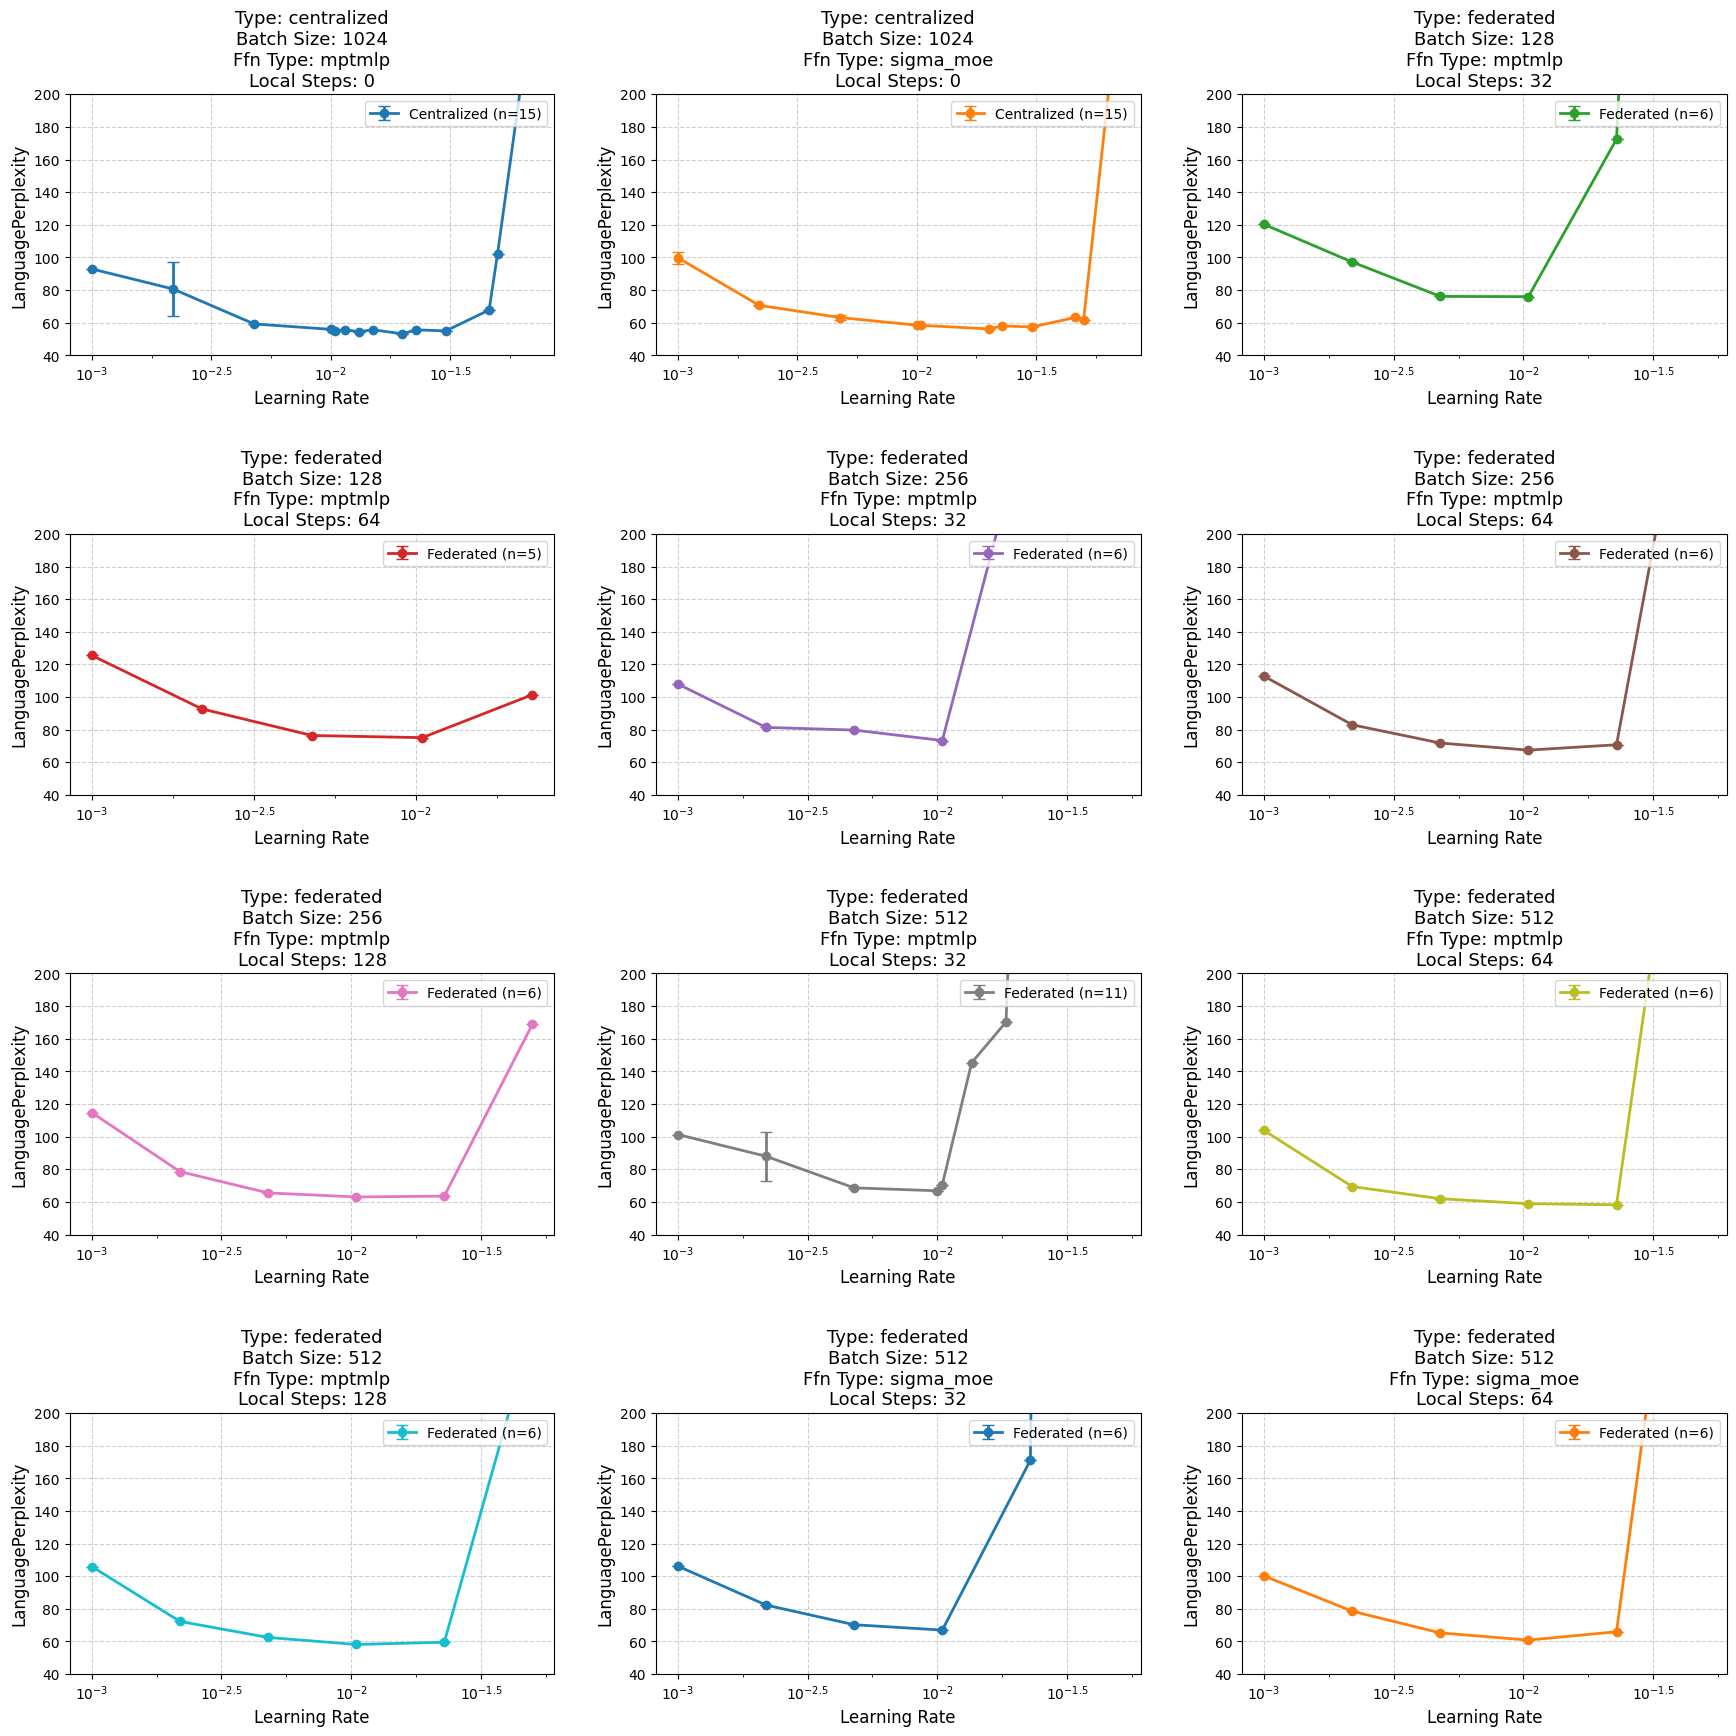

2025-10-16 14:57:28,567 - lr_analysis.ipynb - ERROR - Aggregated LR vs LanguagePerplexity table:
experiment_type  batch_size  ffn_type  local_steps  learning_rate  mean_metric  std_metric  n_runs
    centralized        1024    mptmlp            0         0.0010      92.9940      0.0000       1
    centralized        1024    mptmlp            0         0.0022      80.7087     16.5151       2
    centralized        1024    mptmlp            0         0.0048      59.2687      0.0000       1
    centralized        1024    mptmlp            0         0.0100      55.9463      0.0000       1
    centralized        1024    mptmlp            0         0.0105      55.0420      0.0000       1
    centralized        1024    mptmlp            0         0.0114      55.8496      0.0000       1
    centralized        1024    mptmlp            0         0.0131      54.4299      0.0000       1
    centralized        1024    mptmlp            0         0.0150      55.7003      0.0000       1
    centrali

In [9]:
# 1. Define filters for the experiments.
CONFIG_FILTERS = {
    # 'llm_config.global_train_batch_size': 512,
    # 'llm_config.model.ffn_config.ffn_type': 'mptmlp',
}

# 2. Choose the loss metric to plot.
LOSS_METRIC = "metrics/train/LanguagePerplexity"  # Or 'loss/validation'
METRICS_TO_DOWNLOAD = [LOSS_METRIC]
Y_LIMITS: tuple[float, float] | None = (40, 200)  # Example: (40, 200)
GROUPING_CONFIG_KEYS = DEFAULT_GROUPING_CONFIG_KEYS.copy()
LR_SIG_DIGITS = 2  # Number of significant digits for learning rate axis

# 3. Fetch and group all experiments from W&B.
all_experiments = fetch_and_group_experiments(WANDB_ENTITY, WANDB_PROJECT)

# 4. Filter experiments based on completion and configuration.
if all_experiments:
    filtered_experiments = filter_experiments(all_experiments,
                                              config_filters=CONFIG_FILTERS,
                                            )
else:
    filtered_experiments = []

# 5. Process filtered experiments to get data, using cache if available.
if filtered_experiments:
    results_df = process_experiments(filtered_experiments, metrics=METRICS_TO_DOWNLOAD)
else:
    results_df = pd.DataFrame()

# 6. Generate and display the plots.
if not results_df.empty:
    log.error("\n--- Plot Generation ---")
    generate_plots(
        results_df,
        loss_metric_key=LOSS_METRIC,
        y_limits=Y_LIMITS,
        grouping_config_keys=GROUPING_CONFIG_KEYS,
        lr_sig_digits=LR_SIG_DIGITS,
    )
else:
    log.warning("\nNo data available to generate plots after filtering.")

## Comparison Plots (Optional)

Use this section to compare different experiment configurations (e.g., different FFN types) as separate lines in the same plot.

2025-10-16 14:57:28,698 - lr_analysis.ipynb - ERROR - 
--- Comparison Plot Generation ---


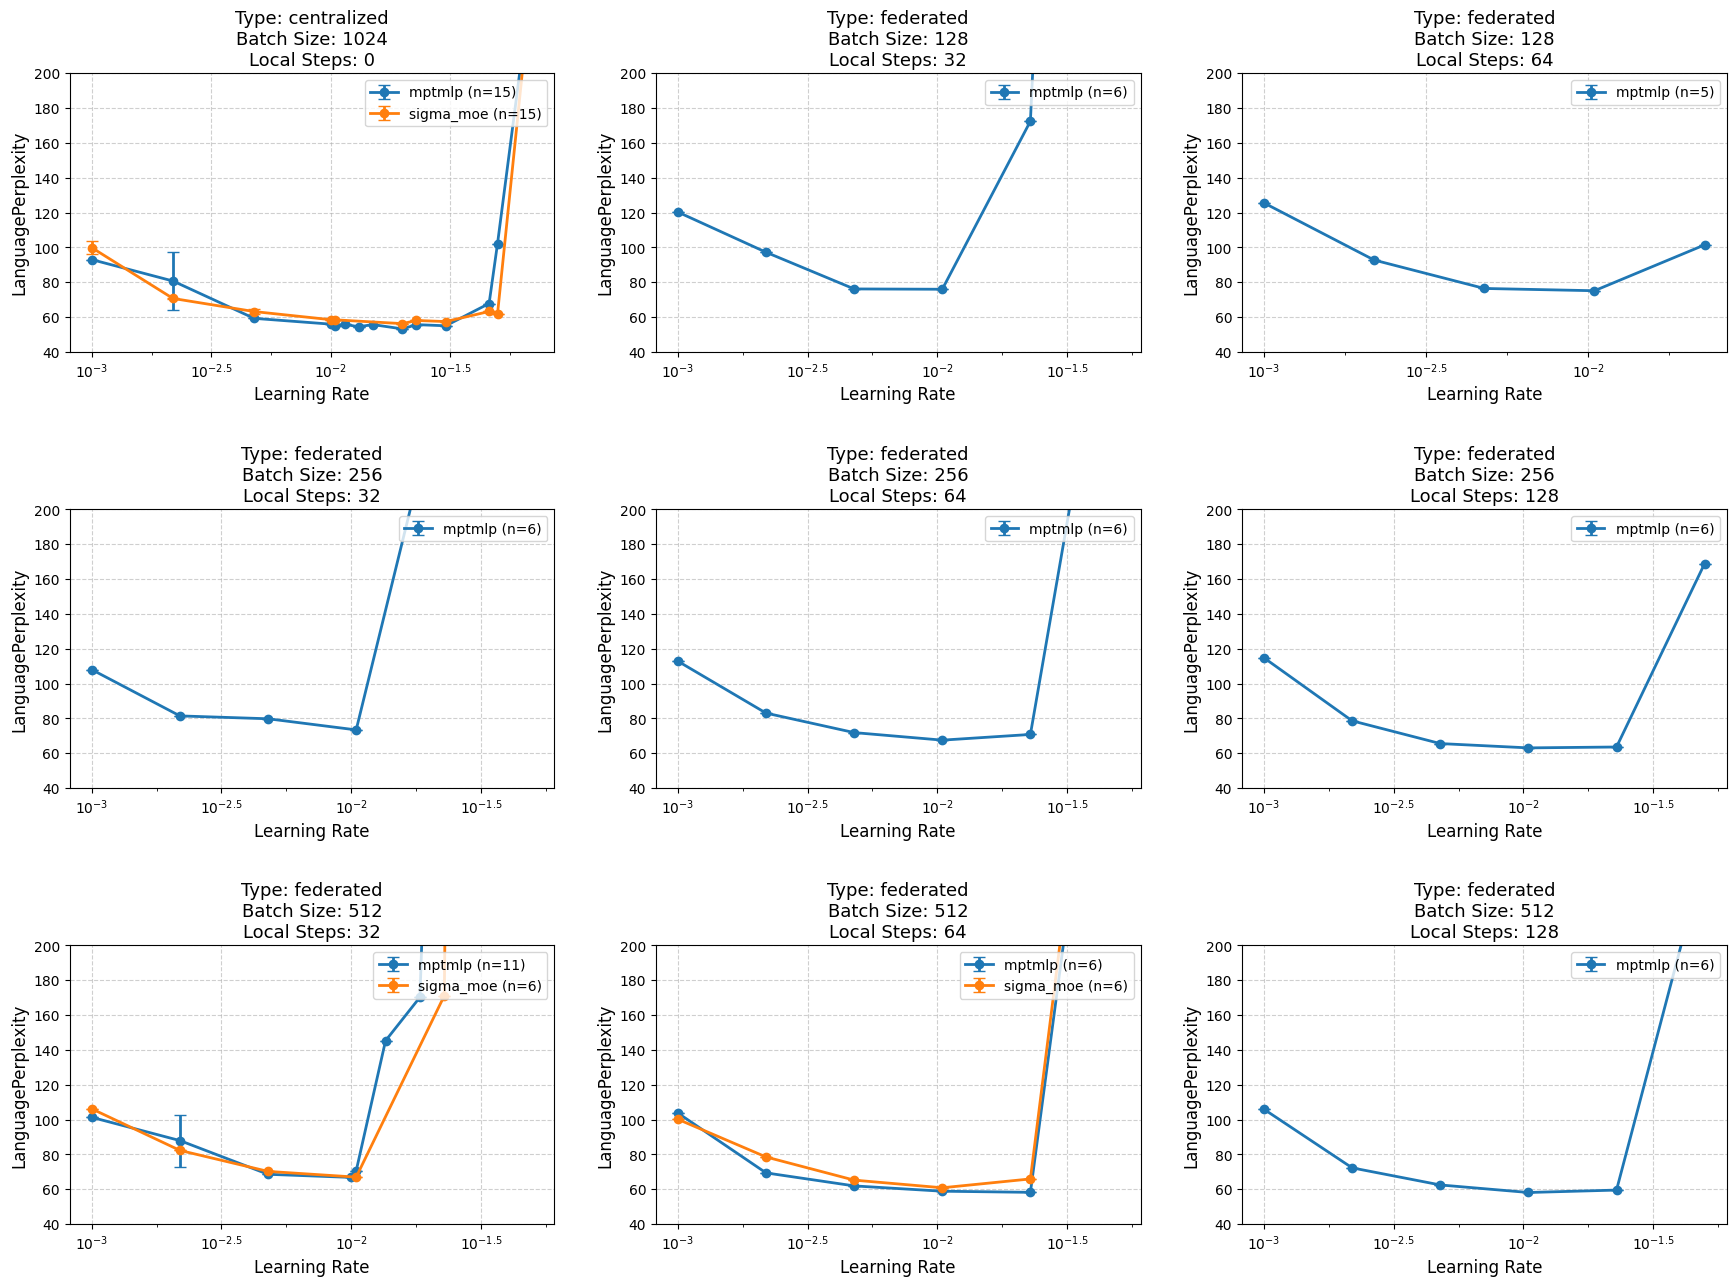

2025-10-16 14:57:29,518 - lr_analysis.ipynb - ERROR - Aggregated comparison for LanguagePerplexity:
experiment_type  batch_size  local_steps  learning_rate  ffn_type  mean_metric  std_metric  n_runs
    centralized        1024            0         0.0010    mptmlp      92.9940      0.0000       1
    centralized        1024            0         0.0010 sigma_moe      99.8346      3.5610       2
    centralized        1024            0         0.0022    mptmlp      80.7087     16.5151       2
    centralized        1024            0         0.0022 sigma_moe      70.6957      0.2414       2
    centralized        1024            0         0.0048    mptmlp      59.2687      0.0000       1
    centralized        1024            0         0.0048 sigma_moe      63.1683      1.2995       2
    centralized        1024            0         0.0100    mptmlp      55.9463      0.0000       1
    centralized        1024            0         0.0100 sigma_moe      58.5080      0.0000       1
    centr

In [10]:
# Example: Compare different FFN types on the same plot
# Each line will represent a different FFN type (mptmlp vs sigma_moe)
# while grouping by batch_size and local_steps

if not results_df.empty:
    log.error("\n--- Comparison Plot Generation ---")
    generate_comparison_plots(
        results_df,
        loss_metric_key=LOSS_METRIC,
        comparison_key="ffn_type",  # Change this to compare different config keys
        y_limits=Y_LIMITS,
        grouping_config_keys=GROUPING_CONFIG_KEYS,
    )
else:
    log.warning("\nNo data available to generate comparison plots.")